# Table of Contents

- [Introduction](#introduction)
- [Data Preprocessing](#data-preprocessing)
- [Data Cleaning](#data-cleaning)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Model Building](#model-building)
- [Results and Conclusion](#results-and-conclusion)
- [Source](#source)

---
P.S.: To ensure proper rendering of the Folium map in the notebook, please view it on nbviewer by following this [link](https://nbviewer.org/github/hiramsf/DataAnalysis/blob/113023617e01e9f00c2b255141d09e9352db6df4/Electric_Vehicles/ev_charging_stations_berlin.ipynb). GitHub does not support the rendering of dynamic elements like Folium maps directly in notebooks, but nbviewer provides full compatibility for interactive content, allowing you to experience the map as intended.


## Introduction <a name="introduction"></a>

* This project explores the landscape of electric vehicle (EV) charging infrastructure in Berlin, Germany. It utilizes a dataset containing information about EV charging stations, including their locations, operators, public access status, and power capacity. Through data analysis and visualization, the project aims to provide insights into the distribution, density, and accessibility of charging stations across different districts of Berlin and its multiple operators.

## Data Preprocessing <a name="data-preprocessing"></a>


In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import googlemaps
import matplotlib.pyplot as plt
import folium
import statsmodels.formula.api as smf


df = pd.read_excel('broker.xls')
df.head()

,Schlüssel,Adresse,Postleitzahl,Ort,Bezirk,Zugang,Art der Ladeeinrichtung,Anzahl der Ladepunkte,Leistung von Ladepunkt 1 [kW],Anschlusstyp von Ladepunkt 1,Leistung von Ladepunkt 2 [kW],Anschlusstyp von Ladepunkt 2,Leistung von Ladepunkt 3 [kW],Anschlusstyp von Ladepunkt 3,Leistung von Ladepunkt 4 [kW],Anschlusstyp von Ladepunkt 4,Betreiber,Standortnummer,Inbetriebnahmedatum,Datenquelle
0,1,Holzstraße 6,13359,Berlin,Mitte,ja,AC,1,11,AC Steckdose Typ 2,-,-,-,-,-,-,Qwello GmbH,DEQRMEM9J3C11,2023-06-21,Stadt Berlin
1,2,Holzstraße 6,13359,Berlin,Mitte,ja,AC,1,11,AC Steckdose Typ 2,-,-,-,-,-,-,Qwello GmbH,DEQRMEM9J3C21,2023-06-21,Stadt Berlin
2,3,Gabriele-Tergit-Promenade 19,10963,Berlin,Mitte,nein,AC,1,22,AC Steckdose Typ 2,-,-,-,-,-,-,Scandic Hotels Deutschland GmbH,-,2019-07-03,Stadt Berlin
3,4,Aalemannufer 1,13587,Berlin,Spandau,ja,AC,1,3,AC Steckdose Typ 2,-,-,-,-,-,-,ubitricity Gmbh (ElMobileBerlin),DE*UBI*E10013078,2023-10-26,Stadt Berlin
4,5,Adele-Sandrock-Straße LM05,12627,Berlin,Marzahn-Hellersdorf,ja,AC,1,3,AC Steckdose Typ 2,-,-,-,-,-,-,ubitricity Gmbh (ElMobileBerlin),DE*UBI*E10040897,2023-07-15,Stadt Berlin


#### Import Packages and Functions
* In this first code cell, I imported several Python libraries that I will use throughout this project. These libraries include pandas (pd) for data manipulation, numpy (np) for numerical computing, os for interacting with the operating system, dotenv for loading environment variables from a .env file, googlemaps for accessing the Google Maps API, matplotlib.pyplot (plt) for data visualization, folium for creating interactive maps, and statsmodels.formula.api (smf) for statistical modeling.

#### Read in our Data
* Data is imported from an Excel file named 'broker.xls' into a pandas DataFrame named df. This DataFrame represents the dataset containing information about charging stations in Berlin. The dataset can be accessed [here](https://daten.berlin.de/datensaetze/%C3%B6ffentlich-zug%C3%A4ngliche-ladeinfrastruktur-f%C3%BCr-e-fahrzeuge-wms). To examine the structure and contents of the data, the head() method is used to display the first few rows of the DataFrame.

# Data Preprocessing (cont.)

In [2]:
# Process to create a new column 'Full address' from the columns 'Adresse', 'Postleitzahl' and 'Ort'

# Change data type of 'Postleitzahl' to avoid concatenation errors
df['Postleitzahl'] = df['Postleitzahl'].astype(str)

# Concatenate the three columns into a newly created column 'Full address'
df['Full address'] = df['Adresse'] + ', ' + df['Postleitzahl'] + ' ' + df['Ort']

# Drop the original columns
df.drop(columns=['Adresse', 'Postleitzahl', 'Ort'], inplace=True)

# Reorder columns to move 'Full address' to the first position
df = df[['Full address'] + [col for col in df.columns if col != 'Full address']]

# Display info() of DataFrame to verify the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Full address                   2197 non-null   object        
 1   Schlüssel                      2197 non-null   int64         
 2   Bezirk                         2197 non-null   object        
 3   Zugang                         2197 non-null   object        
 4   Art der Ladeeinrichtung        2197 non-null   object        
 5   Anzahl der Ladepunkte          2197 non-null   int64         
 6   Leistung von Ladepunkt 1 [kW]  2197 non-null   int64         
 7   Anschlusstyp von Ladepunkt 1   2197 non-null   object        
 8   Leistung von Ladepunkt 2 [kW]  2197 non-null   object        
 9   Anschlusstyp von Ladepunkt 2   2197 non-null   object        
 10  Leistung von Ladepunkt 3 [kW]  2197 non-null   object        
 11  Anschlusstyp von 

* Continuing with data pre-processing, the process now involved consolidating address-related information into a single column named 'Full address' by merging 'Adresse', 'Postleitzahl', and 'Ort' columns. To ensure data integrity, we adjusted the data type of the 'Postleitzahl' column and then removed redundant columns. Additionally, we reordered the DataFrame columns for better organization and verified the changes by examining the DataFrame.





# Data Preprocessing (cont.)

In [3]:
# Load and access environment variables from .env file
load_dotenv('env.txt')
API_KEY = os.getenv("API_KEY")

# Initialize Google Maps client 
gmaps = googlemaps.Client(key=API_KEY) 

# Function to geocode addresses and return latitude and longitude
def geocode_address(address):
    geocode_result = gmaps.geocode(address)
    if geocode_result:
        location = geocode_result[0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        return None, None

# Apply the geocode_address function to each address in the 'Full address' column
df['Latitude'], df['Longitude'] = zip(*df['Full address'].apply(geocode_address))

# Display the info() to check the new columns 'Latitude' and 'Longitude'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Full address                   2197 non-null   object        
 1   Schlüssel                      2197 non-null   int64         
 2   Bezirk                         2197 non-null   object        
 3   Zugang                         2197 non-null   object        
 4   Art der Ladeeinrichtung        2197 non-null   object        
 5   Anzahl der Ladepunkte          2197 non-null   int64         
 6   Leistung von Ladepunkt 1 [kW]  2197 non-null   int64         
 7   Anschlusstyp von Ladepunkt 1   2197 non-null   object        
 8   Leistung von Ladepunkt 2 [kW]  2197 non-null   object        
 9   Anschlusstyp von Ladepunkt 2   2197 non-null   object        
 10  Leistung von Ladepunkt 3 [kW]  2197 non-null   object        
 11  Anschlusstyp von 

* Here, the code first loads environment variables from a .env file to access sensitive information (API key). It then retrieves the API key using the os.getenv() function.

* Next, it initializes a Google Maps client using the API key to access the Google Maps API Geocoding service.

* A function named geocode_address() is defined to geocode addresses and return latitude and longitude coordinates using the Google Maps client. This function is applied to each address in the 'Full address' column of the DataFrame using the apply() function.

* Finally, the DataFrame is displayed with the new 'Latitude' and 'Longitude' columns added, containing the geographic coordinates retrieved from the Google Maps API.





In [4]:
# One of the adresses generated NaN Values for latitude and longitude

# Check this observation
df[df.isnull().any(axis=1)]

,Full address,Schlüssel,Bezirk,Zugang,Art der Ladeeinrichtung,Anzahl der Ladepunkte,Leistung von Ladepunkt 1 [kW],Anschlusstyp von Ladepunkt 1,Leistung von Ladepunkt 2 [kW],Anschlusstyp von Ladepunkt 2,Leistung von Ladepunkt 3 [kW],Anschlusstyp von Ladepunkt 3,Leistung von Ladepunkt 4 [kW],Anschlusstyp von Ladepunkt 4,Betreiber,Standortnummer,Inbetriebnahmedatum,Datenquelle,Latitude,Longitude
2106,"Leipziger Platz 19, 10117 Berlin",2107,Mitte,ja,AC,2,22,AC Steckdose Typ 2,22,AC Steckdose Typ 2,-,-,-,-,Berliner Stadtwerke KommunalPartner GmbH,1217714,2023-06-30,Stadt Berlin,NaN,NaN


In [7]:
# It is unclear why google maps Api couldn't retrieve 'Latitude' and 'Longitude' for the Adress Leipziger Straße 19.

# Change these values manually

# Specify the row index where NaN values are present
nan_row_index = df[df.isnull().any(axis=1)].index[0]

# Manually set the latitude and longitude values for the specified row
latitude = 52.5101801594014
longitude = 13.377848367909841

# Update the values in the DataFrame
df.loc[nan_row_index, 'Latitude'] = latitude
df.loc[nan_row_index, 'Longitude'] = longitude

# Check info() of the updated DataFrame to verify changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Full address                   2197 non-null   object        
 1   Schlüssel                      2197 non-null   int64         
 2   Bezirk                         2197 non-null   object        
 3   Zugang                         2197 non-null   object        
 4   Art der Ladeeinrichtung        2197 non-null   object        
 5   Anzahl der Ladepunkte          2197 non-null   int64         
 6   Leistung von Ladepunkt 1 [kW]  2197 non-null   int64         
 7   Anschlusstyp von Ladepunkt 1   2197 non-null   object        
 8   Leistung von Ladepunkt 2 [kW]  2197 non-null   object        
 9   Anschlusstyp von Ladepunkt 2   2197 non-null   object        
 10  Leistung von Ladepunkt 3 [kW]  2197 non-null   object        
 11  Anschlusstyp von 


## Data Cleaning <a name="data-cleaning"></a>


In [8]:
# Extract the year from the 'Inbetriebnahmedatum' column and store it in a new 'Year' column
df['Year'] = df['Inbetriebnahmedatum'].dt.year


# Remove unnecessary columns for the analysis
to_remove = ['Full address', 'Schlüssel', 'Art der Ladeeinrichtung', 'Leistung von Ladepunkt 1 [kW]', 'Anschlusstyp von Ladepunkt 1', 
             'Leistung von Ladepunkt 2 [kW]', 'Anschlusstyp von Ladepunkt 2', 'Leistung von Ladepunkt 3 [kW]',
             'Anschlusstyp von Ladepunkt 3', 'Leistung von Ladepunkt 4 [kW]', 'Anschlusstyp von Ladepunkt 4', 'Standortnummer',
             'Datenquelle']

df.drop(columns=to_remove, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bezirk                 2197 non-null   object        
 1   Zugang                 2197 non-null   object        
 2   Anzahl der Ladepunkte  2197 non-null   int64         
 3   Betreiber              2197 non-null   object        
 4   Inbetriebnahmedatum    2197 non-null   datetime64[ns]
 5   Latitude               2197 non-null   float64       
 6   Longitude              2197 non-null   float64       
 7   Year                   2197 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(3)
memory usage: 128.9+ KB


* For the data cleaning process, the code firstly extracts the year from the 'Inbetriebnahmedatum' column, representing the operational start date, and creates a new column named 'Release Year' to store this information.

* Then, unnecessary columns that are not required for the analysis are identified and stored in a list called 'to_remove'. These columns include various technical details about the charging capacity and location-specific identifiers that are needed for this analysis.

* Finally, the identified unnecessary columns are dropped from the DataFrame using the drop() method, and the memory usage and data types of the DataFrame are displayed using the info() method to provide an overview of the DataFrame's structure.





# Data Cleaning (cont.)

In [9]:
# Convert remaining object type columns into category type to save memory usage.
to_cat = ['Bezirk', 'Zugang', 'Betreiber']

df[to_cat] = df[to_cat].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Bezirk                 2197 non-null   category      
 1   Zugang                 2197 non-null   category      
 2   Anzahl der Ladepunkte  2197 non-null   int64         
 3   Betreiber              2197 non-null   category      
 4   Inbetriebnahmedatum    2197 non-null   datetime64[ns]
 5   Latitude               2197 non-null   float64       
 6   Longitude              2197 non-null   float64       
 7   Year                   2197 non-null   int32         
dtypes: category(3), datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 89.2 KB



# Data Cleaning (cont.)

In [10]:
# Translate remaining German column names into English
deutsch = ['Bezirk', 'Zugang', 'Anzahl der Ladepunkte', 'Betreiber', 'Inbetriebnahmedatum']

english = ['District', 'Public space (y/n)', 'Number of charging points', 'Operator', 'Release_Date']

german_to_english = {deutsch[n]:english[n] for n in range(len(deutsch))}

# Rename column names
df = df.rename(columns=german_to_english)

# Translate values of 'Public space (y/n)' into English
df['Public space (y/n)'] = df['Public space (y/n)'].replace({'ja': 'Yes', 'nein': 'No'})

df.head()

,District,Public space (y/n),Number of charging points,Operator,Release_Date,Latitude,Longitude,Year
0,Mitte,Yes,1,Qwello GmbH,2023-06-21,52.561679,13.379833,2023
1,Mitte,Yes,1,Qwello GmbH,2023-06-21,52.561679,13.379833,2023
2,Mitte,No,1,Scandic Hotels Deutschland GmbH,2019-07-03,52.504703,13.375042,2019
3,Spandau,Yes,1,ubitricity Gmbh (ElMobileBerlin),2023-10-26,52.573230,13.216910,2023
4,Marzahn-Hellersdorf,Yes,1,ubitricity Gmbh (ElMobileBerlin),2023-07-15,52.534282,13.619287,2023



# Data Cleaning (cont.)

In [11]:
# Set unified/standardised Operator names 

df['Operator'] = df['Operator'].replace({'Vattenfall Smarter Living GmbH': 'Vattenfall Smarter Living GmbH',
                                         'Vattenfall InCharge': 'Vattenfall Smarter Living GmbH',
                                         'InCharge AB Vattenfall': 'Vattenfall Smarter Living GmbH'})
df['Operator'] = df['Operator'].replace({'E.ON Drive Infrastructure GmbH': 'E.ON Drive GmbH'})
df['Operator'] = df['Operator'].replace({'TotalEnergies': 'TotalEnergies Charging Solutions Deutschland GmbH'})
df['Operator'] = df['Operator'].replace({'ubitricity Gmbh (ElMobileBerlin)': 'ubitricity GmbH (ElMobileBerlin)',
                                         'ubitricity Gesellschaft für verteilte Energiesysteme mbH': 'ubitricity Gmbh (ElMobileBerlin)'})
df['Operator'] = df['Operator'].replace({'ubitricity Gmbh (ElMobileBerlin)': 'ubitricity GmbH (ElMobileBerlin)'})


# Save cleaned/prepared DataFrame to a new .xlsx file
df.to_excel('charging_stations_berlin.xlsx', index=False)

## Exploratory Data Analysis <a name="exploratory-data-analysis"></a>

* This code cell below generates a map using Folium to visualize the locations of charging stations in Berlin, with markers color-coded to indicate whether each station is publicly accessible or not. Additionally, it includes a legend to explain the color scheme used on the map.

In [12]:
## Geographic distribution

# Create a map centered around Berlin
berlin_map = folium.Map(location=[52.52, 13.405], zoom_start=11)

# Define colors for 'Public space (y/n)' values
color_map = {'Yes': 'RoyalBlue', 'No': 'OrangeRed'}

# Create a legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 20px; left: 20px; width: 130px; height: 90px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
                 ">&nbsp; Public space (y/n) <br>
     &nbsp; <i class="fa fa-map-marker fa-2x" style="color:RoyalBlue"></i>&nbsp; Yes <br>
     &nbsp; <i class="fa fa-map-marker fa-2x" style="color:OrangeRed"></i>&nbsp; No <br>
      </div>
     '''

# Add the legend to the map
berlin_map.get_root().html.add_child(folium.Element(legend_html))

# Add circle markers for each charging station
for index, row in df.iterrows():
    # Determine color based on 'Public access' value
    color = color_map.get(row['Public space (y/n)'], 'gray')  # Default to gray if value not in color_map
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=1.3,  
        fill=True,
        color=color,  # Marker color
        fill_color=color,  # Fill color
        fill_opacity=0.1,  # Opacity of fill
    ).add_to(berlin_map)

# Display the map
berlin_map


# Exploratory Data Analysis (cont.)

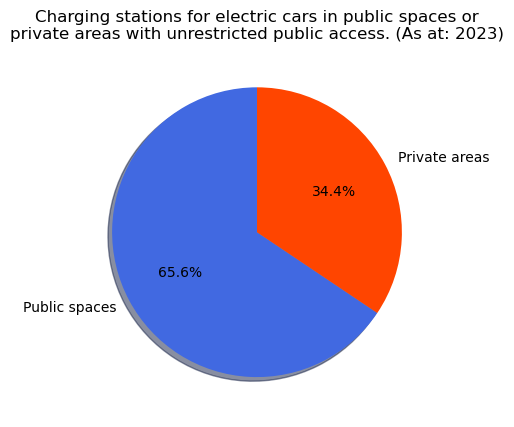

In [13]:
# Define colors
colors = ['RoyalBlue', 'OrangeRed']

# Create pie plot with customized labels and adjusted size
ax = df['Public space (y/n)'].value_counts().plot(kind='pie', colors=colors, autopct='%1.1f%%', startangle=90, shadow=True,
                                                  labels=['Public spaces', 'Private areas'], radius=0.98)

plt.title("Charging stations for electric cars in public spaces or\nprivate areas with unrestricted public access. (As at: 2023)")
ax.set_ylabel('')
ax.set_aspect('equal')
ax;

* The code cell above creates a pie chart to visualize the percentage distribution of charging stations installed in public spaces versus private areas with unrestricted public access. Using the 'Public space (y/n)' column from the DataFrame, it counts the occurrences of 'Yes' and 'No' values, representing public and private installations, respectively. The pie chart is customized with specific colors, labels, and formatting options to enhance readability and clarity of the distribution.


# Exploratory Data Analysis (cont.)

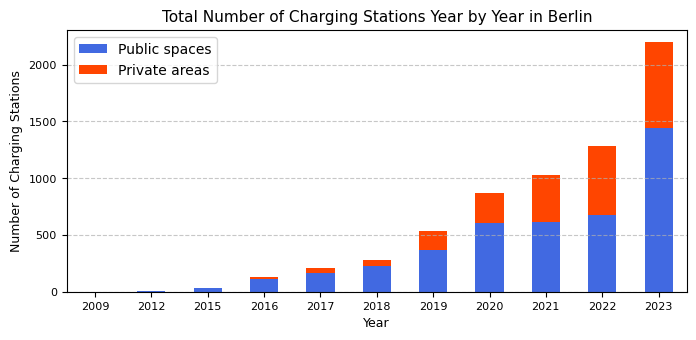

In [14]:
# Sort the DataFrame by 'Year'
df_sorted = df.sort_values(by='Year')

# Group the sorted data by 'Year' and 'Public space (y/n)' and calculate the cumulative sum of charging stations
public_cumulative_years = df_sorted[df_sorted['Public space (y/n)'] == 'Yes'].groupby('Year').size().cumsum()
private_cumulative_years = df_sorted[df_sorted['Public space (y/n)'] == 'No'].groupby('Year').size().cumsum()

# Reindex both arrays to include all years present in the dataset
all_years = df_sorted['Year'].unique()
public_cumulative_years = public_cumulative_years.reindex(all_years, fill_value=0)
private_cumulative_years = private_cumulative_years.reindex(all_years, fill_value=0)

# Create a bar plot to visualize the analysis
plt.figure(figsize=(8, 3.4))
ax = plt.gca()

# Plotting the cumulative number of charging stations year by year for 'yes'
public_cumulative_years.plot(kind='bar', color='royalblue', ax=ax, label='Public spaces')
# Plotting the cumulative number of charging stations year by year for 'no'
private_cumulative_years.plot(kind='bar', color='orangered', ax=ax, bottom=public_cumulative_years, label='Private areas')

ax.set_xlabel('Year', fontsize=9)
ax.set_ylabel('Number of Charging Stations', fontsize=9)
ax.set_title('Total Number of Charging Stations Year by Year in Berlin', fontsize=11)
plt.xticks(rotation=0)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax;

* This code cell performs data manipulation and visualization to illustrate the cumulative number of charging stations installed in Berlin over time, categorized by their location in public spaces or private areas with unrestricted public access. First, the DataFrame is sorted by the 'Release Year' column. Then, the data is grouped by 'Release Year' and 'Public space (y/n)', and the cumulative sum of charging stations is calculated for both categories. Finally, the arrays are reindexed to include all years present in the dataset.


# Exploratory Data Analysis (cont.)

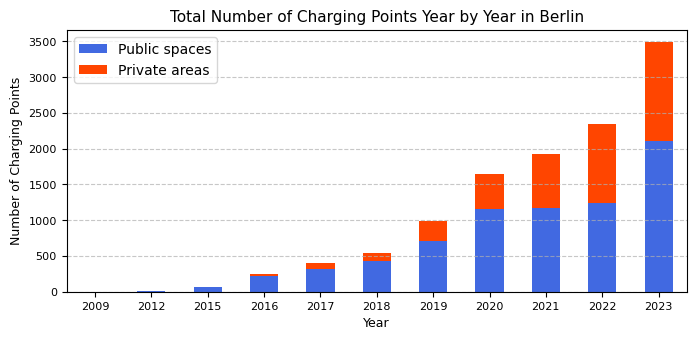

In [15]:
# Group the sorted data by 'Year' and 'Public space (y/n)' and calculate the cumulative sum of charging points
charging_points_public = df_sorted[df_sorted['Public space (y/n)'] == 'Yes'].groupby('Year')['Number of charging points'].sum().cumsum()
charging_points_private = df_sorted[df_sorted['Public space (y/n)'] == 'No'].groupby('Year')['Number of charging points'].sum().cumsum()

# Reindex both arrays to include all years present in the dataset
all_years = df_sorted['Year'].unique()
charging_points_public = charging_points_public.reindex(all_years, fill_value=0)
charging_points_private = charging_points_private.reindex(all_years, fill_value=0)

# Create a new bar plot to visualize the analysis
plt.figure(figsize=(8, 3.4))
ax = plt.gca()

# Plotting the cumulative number of charging points year by year for 'yes'
charging_points_public.plot(kind='bar', color='royalblue', ax=ax, label='Public spaces')
# Plotting the cumulative number of charging points year by year for 'no'
charging_points_private.plot(kind='bar', color='orangered', ax=ax, bottom=charging_points_public, label='Private areas')

ax.set_xlabel('Year', fontsize=9)
ax.set_ylabel('Number of Charging Points', fontsize=9)
ax.set_title('Total Number of Charging Points Year by Year in Berlin', fontsize=11)
plt.xticks(rotation=0)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax;

* Since many charging stations have more than one charging point, so that more than one electric car can be charged at the same time, I decided to analyse the total number of charging points in Berlin over the years. The code cell above focuses on visualizing the cumulative number of charging points installed in Berlin over time, categorized by their location in public spaces or private areas with unrestricted public access. First, the sorted DataFrame is grouped by release year and 'Public space (y/n)', and the cumulative sum of charging points is then calculated for both categories.




# Exploratory Data Analysis (cont.)

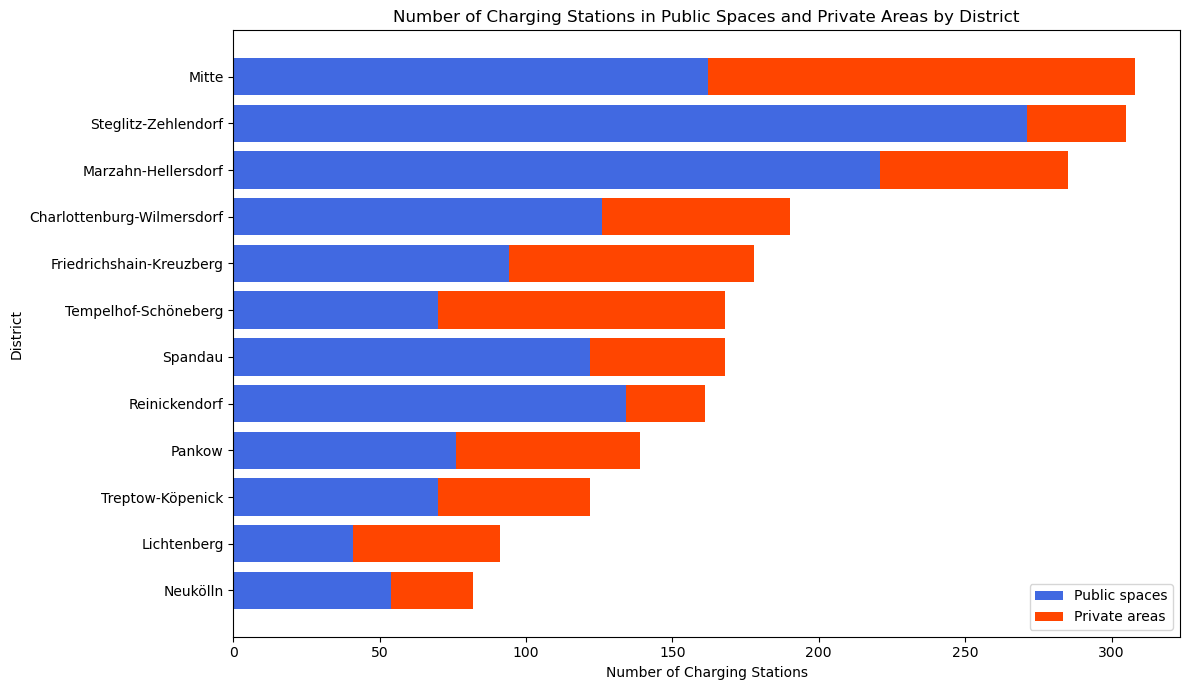

In [16]:
# Generating a cross-tabulation to examine the relationship between districts and the distribution of charging stations
crosstab_district = pd.crosstab(df['District'], df['Public space (y/n)']) 

# Calculate the sum of 'Yes' and 'No' for each district and sorting it based on the total sum
sorted_districts = crosstab_district.sum(axis=1).sort_values()
crosstab_district_sorted = crosstab_district.loc[sorted_districts.index]
crosstab_district_sorted.reset_index(inplace=True)

# Create a new horizontal bar plot to visualize the analysis
plt.figure(figsize=(12, 7))  
plt.barh(crosstab_district_sorted['District'], crosstab_district_sorted['Yes'], label='Public spaces', color='royalblue')
plt.barh(crosstab_district_sorted['District'], crosstab_district_sorted['No'], left=crosstab_district_sorted['Yes'], 
         label='Private areas', color='orangered')
plt.xlabel('Number of Charging Stations')
plt.ylabel('District')
plt.title('Number of Charging Stations in Public Spaces and Private Areas by District')
plt.legend()
plt.tight_layout()
ax;

* This code cell examines the relationship between districts and the distribution of charging stations in Berlin. First, a cross-tabulation is generated to count the occurrences of 'Yes' and 'No' values for public and private charging stations in each district. Then, the districts are sorted based on the total sum of charging stations (descending order), and the cross-tabulation is reordered accordingly.





# Exploratory Data Analysis (cont.)

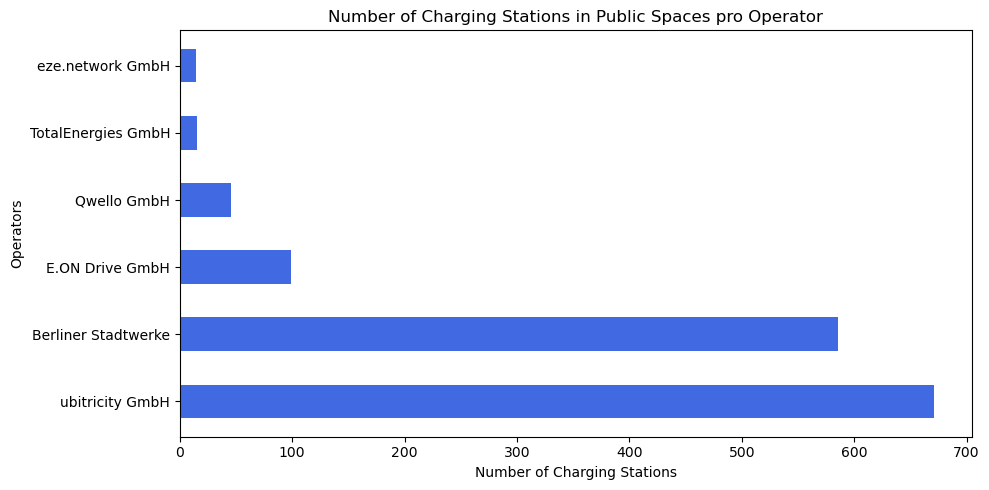

In [17]:
# Replace long operator names with shorter or standardized versions for better visualization of the next plot

df['Operator'] = df['Operator'].replace({'ubitricity GmbH (ElMobileBerlin)': 'ubitricity GmbH'})
df['Operator'] = df['Operator'].replace({'Berliner Stadtwerke KommunalPartner GmbH': 'Berliner Stadtwerke'})
df['Operator'] = df['Operator'].replace({'TotalEnergies Charging Solutions Deutschland GmbH': 'TotalEnergies GmbH'})

# Create crosstab of the 'Operator' column against the filtered 'Public space (y/n)' column ('Yes' values)
# Sort the result by the count of 'Yes' values in descending order.

mask_public = df[df['Public space (y/n)'] == 'Yes']
crosstab_operator_public = pd.crosstab(df['Operator'], mask_public['Public space (y/n)']).sort_values(by='Yes', 
                                                                                                      ascending=False).head(6)
crosstab_operator_public.reset_index(inplace=True)


# Create a new horizontal bar plot to visualize the analysis
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.barh(crosstab_operator_public['Operator'], crosstab_operator_public['Yes'], label='Public spaces', color='royalblue',
         height=0.5)
plt.xlabel('Number of Charging Stations')
plt.ylabel('Operators')
plt.title('Number of Charging Stations in Public Spaces pro Operator')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
plt.tight_layout()
ax;

* This code cell generates a cross-tabulation of the 'Operator' column against the filtered 'Public space (y/n)' column, focusing on 'Yes' values (indicating public spaces). The result is sorted by the count of 'Yes' values in ascending order and the top six operators are selected. A horizontal bar plot is then created to visualize the number of charging stations in public spaces for each operator.


# Exploratory Data Analysis (cont.)

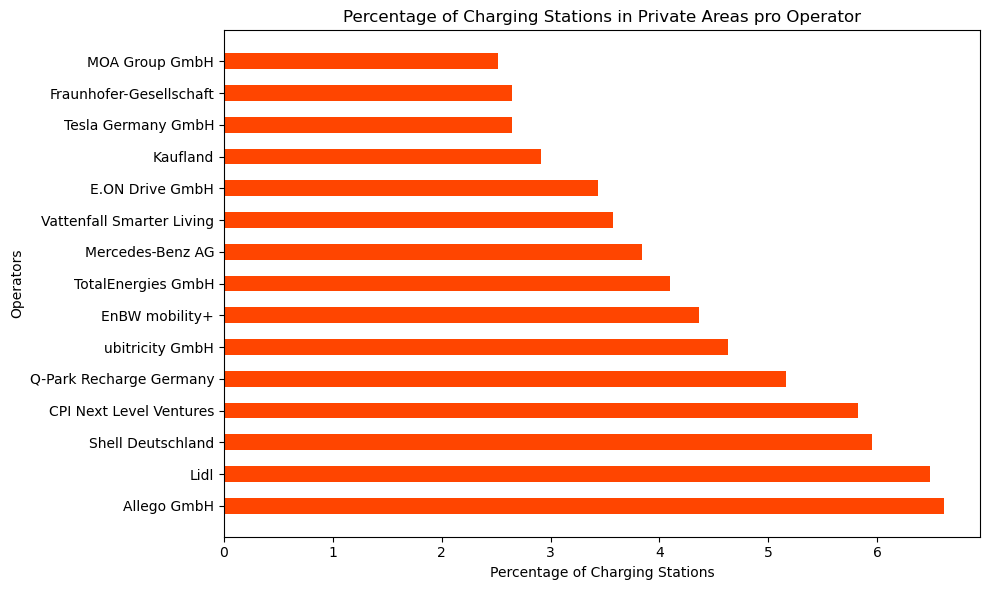

In [18]:
# Replace long operator names with shorter or standardized versions for better visualization of ext plot

df['Operator'] = df['Operator'].replace({'Shell Deutschland GmbH': 'Shell Deutschland'})
df['Operator'] = df['Operator'].replace({'CPI Next Level Ventures GmbH': 'CPI Next Level Ventures'})
df['Operator'] = df['Operator'].replace({'Q-Park Recharge Germany GmbH': 'Q-Park Recharge Germany'})
df['Operator'] = df['Operator'].str.strip().replace({'EnBW mobility+ AG und Co.KG': 'EnBW mobility+'})
df['Operator'] = df['Operator'].replace({'Mercedes- Benz AG - Niederlassung Berlin': 'Mercedes-Benz AG'})
df['Operator'] = df['Operator'].replace({'Vattenfall Smarter Living GmbH': 'Vattenfall Smarter Living'})
df['Operator'] = df['Operator'].replace({'Fraunhofer-Gesellschaft zur Förderung der angewandten Forschung e. V.': 
                                         'Fraunhofer-Gesellschaft'})

# Create crosstab of the 'Operator' column against the filtered 'Public space (y/n)' column ('No' values)
# Sort the result by the count of 'No' values in descending order.

mask_private = df[df['Public space (y/n)'] == 'No']
crosstab_operator_private = pd.crosstab(df['Operator'], mask_private['Public space (y/n)'], 
                                        normalize='columns').sort_values(by='No', ascending=False).head(15) 
# Convert decimals to percentages
crosstab_operator_private *= 100
crosstab_operator_private.reset_index(inplace=True)

# Create a new horizontal bar plot to visualize the analysis
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(crosstab_operator_private['Operator'], crosstab_operator_private['No'], color='orangered', height=0.5)
plt.xlabel('Percentage of Charging Stations')
plt.ylabel('Operators')
plt.title('Percentage of Charging Stations in Private Areas pro Operator')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
plt.tight_layout()
ax;

* The code cell above generates a cross-tabulation of the 'Operator' column against the filtered 'Public space (y/n)' column, focusing on 'No' values (indicating private areas). The resulting table is sorted by the count of 'No' values in ascending order.


# Exploratory Data Analysis (cont.)

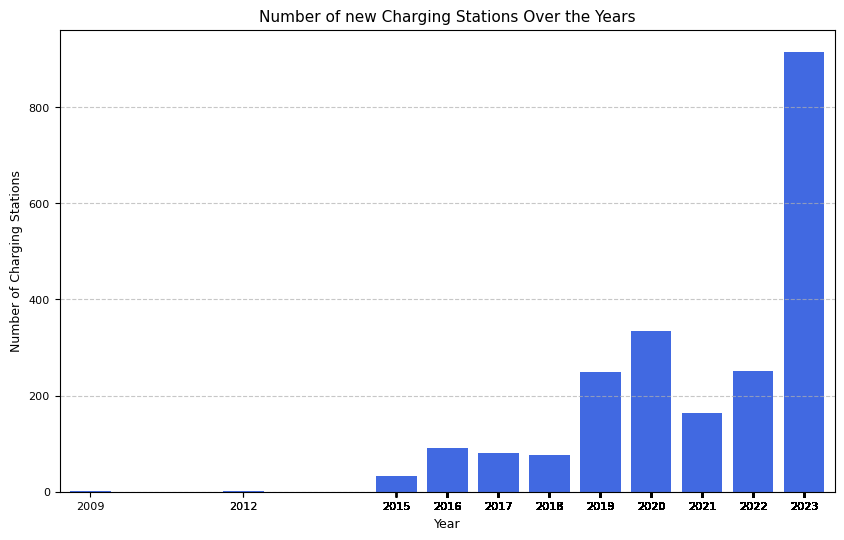

In [21]:
new_c_stations_per_year = df['Year'].value_counts().sort_index()

# Create a bar plot to visualize the analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(new_c_stations_per_year.index, new_c_stations_per_year, color='royalblue')
ax.set_xlabel('Year', fontsize=9)
ax.set_ylabel('Number of Charging Stations', fontsize=9)
ax.set_title('Number of new Charging Stations Over the Years', fontsize=11)
plt.xticks(rotation=0)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlim(df['Year'].min() - 0.6, df['Year'].max() + 0.6)
ax.set_xticks(df['Year'])
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax;

* This code cell calculates the count of charging stations for each release year. Then, it creates a bar plot to visualize the number of new charging stations installed over the years. This number of new charging stations installed pro year is the basis for a kind of 'experiment', detailed in the next section, to predict the number of charging stations that are to be installed in the next years (untill 2030). Given the fact that by 2035 all new passenger cars and light commercial vehicles with combustion motor will be banned in the EU, it is interesting to observe how cities are being prepared to respond for the huge demand for charging stations that will be generated by the increasing number of electric vehicles.  

## Model Building <a name="model-building"></a>


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Num_Charging_Stations   R-squared:                       0.848
Model:                               OLS   Adj. R-squared:                  0.848
Method:                    Least Squares   F-statistic:                 1.226e+04
Date:                   Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                           17:00:44   Log-Likelihood:                -15223.
No. Observations:                   2197   AIC:                         3.045e+04
Df Residuals:                       2195   BIC:                         3.046e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.276e+05   4774.751   -110.506      0.000   -5.37e+05   -5.18e+05
Year         261.6219      2.363    110.737      0.000     256.989     266.255
==============================================================================
Omnibus:                      398.787   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              781.913
Skew:                           1.086   Prob(JB):                    1.62e-170
Kurtosis:                       4.956   Cond. No.                     1.83e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

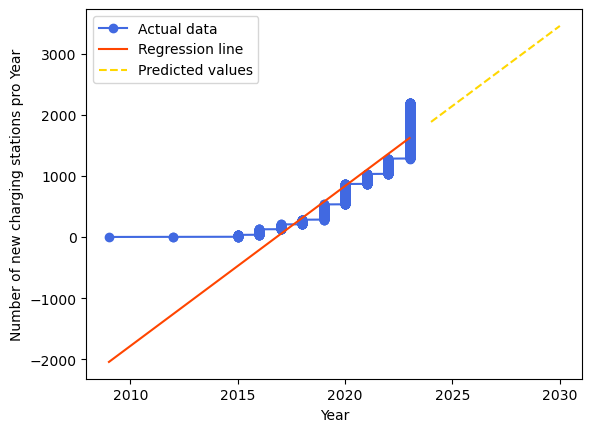

In [22]:
# Sorts DataFrame by 'Release_Date' and adds column with sequential numbers as 'Num_Charging_Stations' to represent the total
# number of charging stations by the corresponding date
df = df.sort_values(by='Release_Date', ascending=True)
df['Num_Charging_Stations'] = range(1, len(df) + 1)

# Defining a model and fitting
model = smf.ols(formula='Num_Charging_Stations ~ Year', data=df)
results = model.fit()

# Check model summary
display(results.summary())

# Generate a DataFrame for the future years
future_years = pd.DataFrame({'Year': range(2024, 2031)})

# Predicting the values
p_y = results.predict(future_years)
p_y_rounded = np.ceil(p_y)

predicted_df = pd.DataFrame({'Year': future_years['Year'], 'Predicted_charging_stations': p_y_rounded})
predicted_df.set_index('Year', inplace=True)
predicted_df

# Plotting
fig, ax = plt.subplots()
# Plot the original data
ax.plot(df['Year'], df['Num_Charging_Stations'], label='Actual data', marker='o', color='royalblue')
# Plot the regression line
ax.plot(df['Year'], results.fittedvalues, label='Regression line', color='orangered')
# Plot the predicted values for future years
ax.plot(future_years['Year'], p_y_rounded, label='Predicted values', linestyle='--', color='gold')

# Set x-axis label
ax.set(xlabel='Year', ylabel='Number of new charging stations pro Year')
# Add legend
ax.legend()
ax;

* Linear Regression
    - This code block performs linear regression analysis to model the relationship between the years and the number of new charging stations installed each year. It then plots the actual data, the regression line, and predicted values for future years.


### Disclaimer: Predictive Analysis of Future Charging Station Installations

The predictive analysis presented herein aims to forecast the potential number of new electric vehicle (EV) charging stations to be installed in Berlin until the year 2030. It is important to note that this analysis serves as an exploratory exercise within the context of this project and does not constitute a definitive forecast or projection of future charging infrastructure development in the city. 


In [23]:
# Retrieve the predicted values for the years 2024 to 2030
predicted_values = predicted_df['Predicted_charging_stations']

# Convert the predicted values to integers
predicted_values = predicted_values.astype(int)

# Print the predicted values for each year
for year, value in predicted_values.items():
    print(f"The predicted number of new EV charging stations in Berlin for the year {year} is {value}.")

print()

charging_stations_by_2030 = df['Num_Charging_Stations'].iloc[-1] + predicted_values.sum()

print(f'The predicted number of charging stations in Berlin by the end of 2030, according to this simple linear \
regression is {int(charging_stations_by_2030)}.', '\n')

median_charge_points = df['Number of charging points'].median()
charging_points_by_2030 = charging_stations_by_2030 * median_charge_points

print(f'Taking into account the median number of charging points per charging station, one can assume that the total number \
of charging points by 2030 will be approximately {int(charging_points_by_2030)}.')

The predicted number of new EV charging stations in Berlin for the year 2024 is 1882.
The predicted number of new EV charging stations in Berlin for the year 2025 is 2144.
The predicted number of new EV charging stations in Berlin for the year 2026 is 2405.
The predicted number of new EV charging stations in Berlin for the year 2027 is 2667.
The predicted number of new EV charging stations in Berlin for the year 2028 is 2929.
The predicted number of new EV charging stations in Berlin for the year 2029 is 3190.
The predicted number of new EV charging stations in Berlin for the year 2030 is 3452.

The predicted number of charging stations in Berlin by the end of 2030, according to this simple linear regression is 20866. 

Taking into account the median number of charging points per charging station, one can assume that the total number of charging points by 2030 will be approximately 41732.



## Results and Conclusion <a name="results-and-conclusion"></a>

#### Following a comprehensive exploration of the electric vehicle charging station network in Berlin, coupled with the application of a basic linear regression model to forecast the projected number of stations by 2030, several noteworthy insights have emerged:

* The cartographic analysis of charging station distribution across the city reveals a slightly elevated density within the central 'Ring' region. However, this density remains moderate. Interestingly, several peripheral districts, such as Steglitz-Zehlendorf in the southwest and Marzahn-Hellersdorf in the northeast, also exhibit a considerable number of installed charging stations. In the southeastern part of the city, districts like Neukölln and Treptow-Köpenick present the lowest absolute counts of charging stations and exhibit the least dense distribution along their streets. More in-depth research is needed to understand why Neukölln, one of the most populous districts in Berlin, has such a small number of EV charging stations compared to other districts such as Mitte.

* An analysis of the geographical distribution across Berlin's urban landscape reveals a higher prevalence of charging stations installed in public spaces compared to private areas, including hotel car parks, supermarkets, and shopping centers. The pie chart proves this impression more precisely. By 2023, around 66% of charging stations were located in public spaces, compared to just 34% in private areas.

* However, by the end of 2022, this distribution was more balanced, with nearly 1500 charging stations in the city, and 55% of them situated in public spaces. In 2023 though, there was a notable surge in the number of charging stations, with approximately 800 new ones, predominantly in public spaces. The substantial increase in new charging stations, particularly those in public spaces, can be attributed to the implementation of the "ElMobileBerlin" project. This project investigates the extent to which an infrastructure of lanterns in public spaces can help to increase the attractiveness of electric mobility by making charging stations as easily accessible as possible. The Senate Department for the Environment, Mobility, Consumer and Climate Protection is leading the project that set up charging stations in public spaces. Over 1000 charging stations were installed on street lamps in public spaces. Mainly in cooperation with "Ubitricity mbH", a Berlin-based subsidiary of the Shell Group, which has been commissioned with the procurement, construction and operation. In addition to Ubricity, a large number of the charging stations installed in public spaces are owned by the Berliner Stadtwerke.

* The analysis on the operators that have installed charging stations in private areas shows a much wider variety of companies involved, but none of them stands out so abruptly from the others. Allego GmbH, Lidl and Shell Deutschland each have around 6 % of the charging stations in this category.

* Finally, a regression analysis was carried out to predict the number of charging stations that will be installed in Berlin by the end of 2030. As already mentioned, this analysis was only intended to demonstrate this type of predictive analysis, since  it was based on a limited dataset containing historical information on charging station installations, along with associated temporal data. While efforts were made to derive insights and trends from the available data, it is acknowledged that the dataset may not capture the full spectrum of factors influencing the installation of charging stations. External factors such as political, economic, and technological developments, as well as evolving consumer behavior and government policies, can significantly impact the adoption and deployment of EV infrastructure.

* Moreover, it is recognized that for a more robust and accurate regression analysis, a larger and more comprehensive dataset would be required. The dataset used in this analysis may lack sufficient granularity and coverage to effectively capture the complex dynamics driving the expansion of charging infrastructure. As such, the predictions generated from this analysis should be interpreted with caution and viewed as hypothetical scenarios rather than precise forecasts.



## Source <a name="source"></a>
### "Geoportal Berlin - Öffentlich zugängliche Ladeinfrastruktur für E-Fahrzeuge".
#### „Datenlizenz Deutschland – Namensnennung – Version 2.0" - [DL-DE->BY-2.0](https://www.govdata.de/dl-de/by-2-0)
* Data basis:
    - Energy Atlas Berlin, Senate Department for Economics, Energy and Public Enterprises (SenWEB), online as of December 2023
    - Locations: Federal Network Agency and Senate Department for Mobility, Transport, Climate Protection and the Environment (SenMVKU), as at 1 December 2023
    - Blocked spaces: Senate Department for Mobility, Transport, Climate Protection and the Environment (SenMVKU), as at 08/09/2023
    - Possible impact on cycling network: Senate Department for Mobility, Transport, Climate Protection and the Environment (SenMVKU), as at 20/05/2022